# Composite Figure

## Import package

In [113]:
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib import spines as sp

## Figure 01: Raw Composite for the CCKWs in CNTL

### Load data

In [114]:
# file path
path: str = "/work/b11209013/2024_Research/MPAS/merged_data/CNTL/"

# load selected events
sel_events: dict       = np.load(
    "/home/b11209013/Bachelor_Thesis/CCKW_sel/Selected_Events/q1_sel_CNTL.npz",
    allow_pickle=True
    )
sel_time  : np.ndarray = sel_events["selected_events_time"]
sel_lon   : np.ndarray = sel_events["selected_events_lon"]

# load MPAS data
data: dict[str, np.ndarray] = dict()

with nc.Dataset(f"{path}q1.nc") as f:
    dims: dict[str, np.ndarray] = dict(
        (key, np.array(f.variables[key][:]))
        for key in f.dimensions.keys()
    )

    lat_lim: np.ndarray = np.where(
        (dims["lat"] >= -5) & (dims["lat"] <= 5)
    )[0]

    dims["lat"]  = dims["lat"][lat_lim]
    dims["time"] = dims["time"][:360]

    data["q1"] = np.array(f.variables["q1"][:360, :, lat_lim, :])*86400/1004.5

with nc.Dataset(f"{path}theta.nc") as f:
    data["theta"] = np.array(f.variables["theta"][:360, :, lat_lim, :])

data["t"] = (data["theta"] * (1000/dims["lev"][None, :, None, None])**-0.286)

data.pop("theta")

with nc.Dataset(f"{path}qv.nc") as f:
    data["qv"] = np.array(f.variables["qv"][:360, :, lat_lim, :])*1000

## Processing data

In [115]:
# averaged over latitude
data = dict(
    (key, np.mean(data[key], axis=2))
    for key in data.keys()
)

# remove climatology and zonal mean
data_rm_cli: dict[str, np.ndarray] = dict(
    (key, data[key] - np.mean(data[key], axis=(0, 2), keepdims=True))
    for key in data.keys()
)

In [116]:
print(data_rm_cli["q1"])

[[[ 1.88776925e-01  3.49030226e-01  3.41070533e-01 ...  7.71756113e-01
    4.06648934e-01  3.86567980e-01]
  [ 1.82159305e-01  2.94037223e-01  3.88765931e-01 ...  5.38348496e-01
    2.16275454e-01  3.62489432e-01]
  [ 3.49990904e-01  4.23708320e-01 -2.16960162e-01 ... -2.91254193e-01
   -5.59064269e-01 -8.42684209e-02]
  ...
  [ 2.90938497e-01 -1.63156033e-01  4.73764062e-01 ... -1.88998270e+00
   -1.26246524e+00 -1.15852427e+00]
  [ 1.48944807e+00 -2.61240578e+00 -5.15693283e+00 ...  6.10613823e-03
    2.05695415e+00  3.23675346e+00]
  [-1.50237727e+00 -5.69199181e+00 -9.38699341e+00 ...  1.32025003e-01
    6.92770481e-01 -3.75858068e-01]]

 [[-6.64380133e-01 -6.24861240e-01 -4.33678240e-01 ...  3.88503611e-01
    5.33066951e-02 -2.71443009e-01]
  [-5.16836226e-01 -5.12506366e-01 -3.13636154e-01 ...  3.70288312e-01
    8.03062990e-02 -2.09718525e-01]
  [-5.65055966e-01 -4.61960435e-01 -7.33925104e-02 ...  2.67587245e-01
   -1.84849054e-01 -2.45625973e-01]
  ...
  [-2.42092824e+00 -2.2

In [117]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

## Events selection

In [118]:
data_sel: dict[str, np.ndarray] = dict()

for key in data_rm_cli.keys():
    temp_data = list()
    for t in range(sel_time.shape[0]): # for seleting time
        for l in sel_lon[t]: # for selecting longitude in each time
            temp_data.append(data_rm_cli[key][sel_time[t], :, l].T)

    data_sel[key] = np.array(temp_data).mean(axis=0)

### Composite

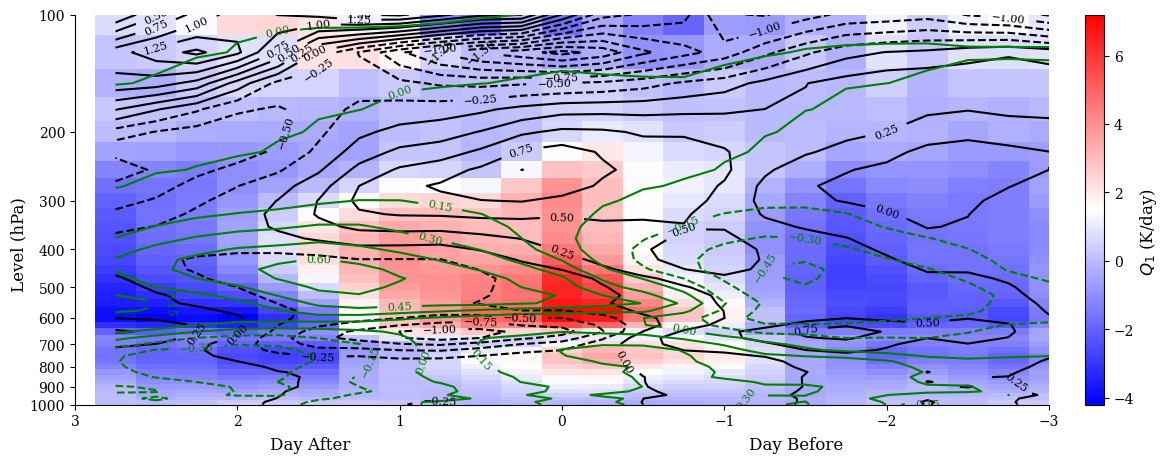

In [122]:
plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(12, 5))
pc = plt.pcolormesh(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["q1"],
    cmap="bwr"
    )
c1 = plt.contour(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["t"],
    colors="k",
    levels=np.arange(-1.75, 1.51, 0.25)
    )
c2 = plt.contour(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["qv"],
    colors="green",
    levels=np.arange(-0.45, 0.65, 0.15)
    )
plt.yscale("log")
plt.xticks(np.linspace(-3, 3, 7))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.xlim(-3, 3)
plt.ylim(100, 1000)
plt.text(1.8, 1300, "Day After", fontsize=12)
plt.text(-1.15, 1300, "Day Before", fontsize=12)
plt.text(3.4, 500, "Level (hPa)", fontsize=12, rotation=90)
plt.text(-3.55, 450, r"$Q_1$ (K/day)", fontsize=12, rotation=90)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(pc, pad=0.03)
plt.clabel(c1, inline=True, fontsize=8)
plt.clabel(c2, inline=True, fontsize=8)
plt.subplots_adjust(left=0.07, right=1.06, top=0.9, bottom=0.12)

axes = fig.gca()
axes.spines["top"].set_linewidth(0)
axes.spines["right"].set_linewidth(0)

plt.savefig("CCKW_sel_CNTL.png", dpi=300)